In [12]:
SS_MODEL = "ss/sentencespace"
GITHUB_RESULTS = 'conferences/gh_responses.jl'
GITHUB_EMBEDDINGS = 'ss/ss_repo_embeds_100_1gram.txt'
DIMS=100

# make CONFS a falsey value to return all conferences
CONFS = ['UAI', 'ICML', 'COLT', 'NIPS', 'AISTATS']

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from lib.utils import *
from repoman.filter_responses import get_repos_titles
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
size = int(5472100/2)
embeddings = get_embeddings(GITHUB_EMBEDDINGS, size, dims=DIMS)

In [ ]:
repos = get_repos_titles(GITHUB_RESULTS, CONFS, 12)    

In [8]:
readmes = get_ai_readmes(repos, workers=15)

In [13]:
vecs = embed_docs(SS_MODEL, '\n'.join(readmes))

## Classification algorithm: One-Class SVM

The Support Vector Machine is a classic machine-learning algorithm that draws a boundary in the geometric space (in our case, the space created by a Gaussia kernel) of the problem, classifying all points on one side of the boundary as positive and those on the other side as negative. 

One-class SVM seeks to draw this boundary after having only seen positive points. It can be thought of as drawing a sphere around the positive points it is trained on, and shrinking that sphere as much as possible: trading off between minimizing the volume of the sphere and maximizing the amount of points it keeps inside of it (correctly classified). 

Drawing a small random sample from the embedded space around the medoid AI repository, we can visualize the work of the classifier in the following figure. The model has one tuning parameter: $\nu$, which allows us set an upper bound, in fractional terms, on how many positive labels we leave outside of the decision boundary (incorrectly labelled). In our case, we choose to leave up to 50% of the original readmes outside the boundary (the squares with the "Not AI" label in figure ???). 

In [14]:
svm = OneClassSVM(kernel='rbf', nu = .4, gamma = 1/1000)

In [15]:
from scipy.spatial.distance import euclidean, cosine
from hdmedians import geomedian, medoid

def distance_from(arr, v):
    dist = lambda d: euclidean(d, v)
    return np.apply_along_axis(lambda d: euclidean(d, v), 1, arr)

def distances_from_med(vecs, embeddings, med = None):
    """ Generate distance of each embedding from medoid of vecs """
    med = med or np.asarray(medoid(vecs.T))
    return distance_from(embeddings, med)

def pick_local_sample(distances, embedding, sample_size, thresh):
    s = embeddings[distances < thresh]
    idx = np.random.choice(s.shape[0], sample_size, replace=False)
    sample = s[idx]
    return sample

In [16]:
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE

def project(embeddings, vecs):
    mds = MDS()
    X = np.concatenate([vecs, embeddings])
    manifold = mds.fit_transform(X)
    labels = np.concatenate([np.ones(vecs.shape[0]), np.zeros(embeddings.shape[0])])
    df = pd.DataFrame(manifold, columns = ['x', 'y']).assign(source = pd.Series(labels))
    return df
    
def plot_predictions(model, df):
    df = df.copy()
    X = df[['x', 'y']].values
    vecs = X[df.source == 1]
    pos,mod = predict_ai(model, vecs, X)
    
    # Add support vectors
    df['support_vector'] = False
    df.loc[mod.support_ ,'support_vector'] = True
    
    # Add labels for source
    lab = df.source.map(lambda i: 'Not-AI')
    lab[pos[:,0]] = 'AI'
    df['label'] = lab
    df['source'] = df.source.map(lambda i: 'Conferences' if i == 1 else 'Random')
    sns.scatterplot(x = 'x', y = 'y', style='source', hue = 'label', data = df, markers = [',', 'P'], palette="bright")

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [17]:
distances = distances_from_med(vecs, embeddings)

In [18]:
sample = pick_local_sample(distances, embeddings, sample_size=1000, thresh=1.2)
sample_vecs = vecs[np.random.choice(vecs.shape[0], 500, replace=False)]

In [19]:
df = project(sample, sample_vecs)

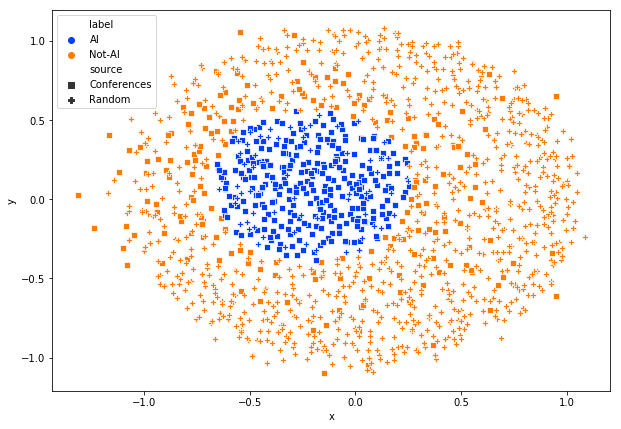

In [20]:
plot_predictions(svm, df)